# What are the most demanded skills for the top 3 most popular data roles?

#### Methodology

1. Clean-up skill column
2. Calculate skill count based on 'job_title_short'
3. Calculate skill percentage
4. Plot final findings

### Import Libraries and Data

In [2]:
# Importing Libraries
import seaborn as sns
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import ast 

# Load Datasets
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

# Data Cleanup (Datetime conversion & 'job_skills' to list type)
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda skill_list: ast.literal_eval(skill_list) if pd.notna(skill_list) else skill_list) 

### Filter Data for the USA

In [3]:
# Filter for US jobs only
df_US = df[df['job_country'] == 'United States']

### Explode Skills

In [99]:
# Split up job skills into individual rows
df_skills = df_US.explode('job_skills')

df_skills[['job_title_short', 'job_title', 'job_skills']] # Check out df_skills

,job_title_short,job_title,job_skills
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,None
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,python
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,c++
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,java
3,Data Engineer,LEAD ENGINEER - PRINCIPAL ANALYST - PRINCIPAL ...,matlab
...,...,...,...
785692,Data Scientist,Data Scientist- Hybrid Work Location,r
785703,Data Analyst,Data Analyst - CRYPTOGRAPHY - Full-time,None
785705,Data Analyst,Expert Business Data Analyst - Now Hiring,sql
785705,Data Analyst,Expert Business Data Analyst - Now Hiring,python


### Count Skills per Job Title

Groups DataFrame by `job_skills` and `job_title_short`, counting the occurrences of each skill within each job title. Then resets the index of the Series to turn it back into a DataFrame and renames the series holding the count to 'skill_count'. The final DataFrame, `df_skills_count`, shows the frequency of each skill with each job title.

In [100]:
df_skills_count = df_skills.groupby(['job_skills','job_title_short']).size().reset_index(name = 'skill_count')
# .groupby() usually returns a series data type; .reset_index() to convert back to a DataFrame 
# note: size() counts all rows in the group inclulding NaN values; count() only counts NON-NaN values; Use .agg() for multiple aggregations

df_skills_count = df_skills_count.sort_values(by='skill_count', ascending=False)

df_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
553,gdpr,Software Engineer,1
554,ggplot2,Business Analyst,1
1843,wrike,Business Analyst,1
1839,workfront,Data Engineer,1


### Create List of Top 3 Roles

Focus: Data Analysts, Data Engineers, and Data Scientists

Filter the job titles based on the most popular.

In [45]:
job_titles = sorted(df_US['job_title_short'].value_counts().head(3).index.tolist()) # Finds top 3 job titles with highest count of postings and converts to list 

job_titles

['Data Analyst', 'Data Engineer', 'Data Scientist']

### Plot Skill Counts

Creates a stacked horizontal bar chart for the top 5 skills for Top 3 roles, displaying the frequency of each skill.

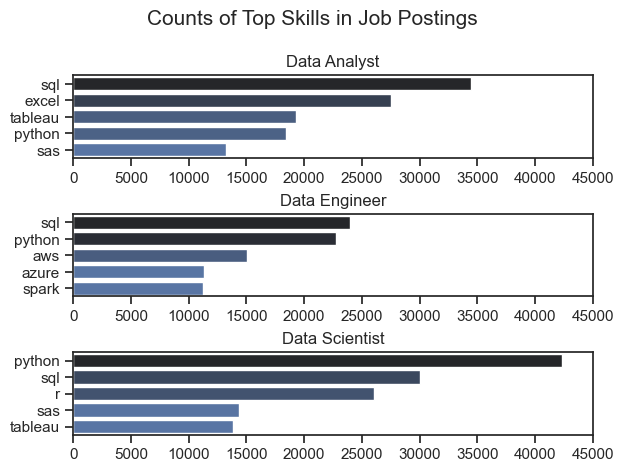

In [105]:
# Visualization (Counts)

fig, ax = plt.subplots(len(job_titles), 1) # Rows (is the length of the job_titles list), cols = 1

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_count[df_skills_count['job_title_short'] == job_title].head(5)
    # df_plot.plot(kind = 'barh', x = 'job_skills', y = 'skill_count', ax = ax[i], title = job_title)
    sns.barplot(data=df_plot, x='skill_count', y='job_skills', ax=ax[i], hue='skill_count', palette='dark:b_r')
    # ax[i].invert_yaxis()
    ax[i].set_title(job_title)
    ax[i].set_ylabel('')
    ax[i].set_xlabel('')
    ax[i].set_xlim(0,45000)
    ax[i].legend().set_visible(False)

fig.suptitle('Counts of Top Skills in Job Postings', fontsize = 15)
fig.tight_layout(h_pad=0.5)
plt.show()

### Convert Counts to Percentages
#### Focus: Counts don't show what portions of jobs are requesting these skills
So we'll convert the counts into percentages which helps us understand how each job title represents relative to the entire dataset.

Before we can calculate the percentages we need the total counts for the jobs posted by job title. Calculate the frequency of each job title using the value_counts() method on the job_title_short column. Then reset the index to transform the Series into a DataFrame and renames the columns to job_title_short and total. The DataFrame df_job_title_count now holds a list of job titles alongside their total occurrences.

In [106]:
# Finding the total job postings per unique job title in the US dataframe
df_job_title_count = df_US['job_title_short'].value_counts().reset_index(name='jobs_total')

df_job_title_count

,job_title_short,jobs_total
0,Data Analyst,67816
1,Data Scientist,58830
2,Data Engineer,35080
3,Senior Data Scientist,12946
4,Senior Data Analyst,11791
5,Senior Data Engineer,9289
6,Business Analyst,7382
7,Software Engineer,1814
8,Machine Learning Engineer,921
9,Cloud Engineer,423


In [75]:
# Merging the job counts df with the skills count df

df_skills_perc = pd.merge(df_skills_count, df_job_title_count, how='left', on='job_title_short') # Left join (Everything from left table will be maintained)

df_skills_perc['skill_perc'] = (df_skills_perc['skill_count'] / df_skills_perc['jobs_total'])*100

df_skills_perc

,job_skills,job_title_short,skill_count,jobs_total,skill_perc
0,python,Data Scientist,42379,58830,72.036376
1,sql,Data Analyst,34452,67816,50.802171
2,sql,Data Scientist,30034,58830,51.052184
3,excel,Data Analyst,27519,67816,40.578919
4,r,Data Scientist,26022,58830,44.232534
...,...,...,...,...,...
1865,gdpr,Software Engineer,1,1814,0.055127
1866,ggplot2,Business Analyst,1,7382,0.013546
1867,wrike,Business Analyst,1,7382,0.013546
1868,workfront,Data Engineer,1,35080,0.002851


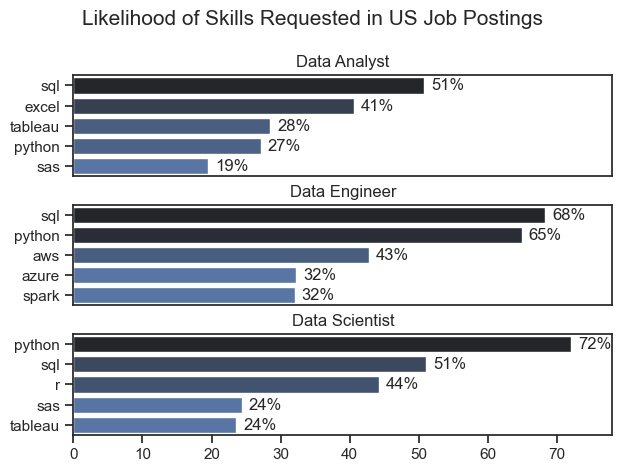

In [96]:
# PLOTTING - Final Version

fig, ax = plt.subplots(len(job_titles), 1) # Rows (is the length of the job_titles list), columns = 1

sns.set_theme(style='ticks')

for i, job_title in enumerate(job_titles):
    df_plot = df_skills_perc[df_skills_perc['job_title_short'] == job_title].head(5)
    # df_plot.plot(kind = 'barh', x = 'job_skills', y = 'skill_perc', ax = ax[i], title = job_title) # Not required - We've converted to Seaborn plot now
    sns.barplot(data=df_plot, x = 'skill_perc', y = 'job_skills', ax=ax[i], hue = 'skill_perc', palette = 'dark:b_r')
    # ax[i].invert_yaxis() # Seaborn doesn't automatically invert the yaxis tick labels so we dont require this line
    ax[i].set_title(job_title)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].set_xlim(0,78) # So all subplots are on the same axis
    ax[i].legend().set_visible(False)

    if i != len(job_titles) - 1:
        ax[i].set_xticks([]) # Removes the x axis ticks & labels apart from the last subplot

    for n, v in enumerate(df_plot['skill_perc']): # For the % labels for each individual bar
        ax[i].text(v + 1, n, f'{v:.0f}%', va = 'center')

fig.suptitle('Likelihood of Skills Requested in US Job Postings', fontsize = 15)
fig.tight_layout(h_pad=0.5)
plt.show()